In [1]:
import numpy as np
seed = 42069
np.random.seed(seed)
import pandas as pd
from matplotlib import pyplot as plt
import arviz
import pystan
from scipy import sparse, stats
from typing import Iterable, Union, Callable
from sklearn.model_selection import train_test_split, ParameterGrid
import altair as alt
from time import time, sleep
from tqdm import tqdm

# Own files
import utils 
import StanClasses

# Load and preprocess data

The data we have is essentially a matrix, where the each row correspond to a person, and each column correspond to a movie. However, the matrix is very sparse and thus data is stored in sparse format (i.e. specified with indices and the corresponding values). 

In [2]:
# Define constants
DATA_DIR = 'ml-100k'

In [3]:
df, _, _ = utils.get_ml100k_data(DATA_DIR, subsample_top_users=200, subsample_top_items=30)
df[['user_id', 'item_id']] -= 1

# We are not going to use timestamp, therefore drop it
df.drop('timestamp', axis='columns', inplace=True)

The user ids and item (movie) ids are essentially integer ranges, starting from and 1 to the number of users and items respectively. We don't have the all the unique ids when subsampling users and movies. It becomes problematic ... TODO: Write this

In [4]:
def column_relabler(df: pd.DataFrame, column: str):
    uniques = pd.value_counts(df[column], sort=False).index.values
    n_uniques = len(uniques)

    # Count from 1 to conform with Stan (Stan counts indexes arrays starting at 1)
    num2id = {num_:id_ for num_, id_ in zip(range(0, n_uniques), uniques)}
    id2num = {id_:num_ for num_, id_ in zip(range(0, n_uniques), uniques)}
    
    df[column] = df[column].map(id2num)
    return id2num, num2id

df_num = df.copy()
user2num, num2user = column_relabler(df_num, 'user_id')
item2num, num2item = column_relabler(df_num, 'item_id')

# p, q represents shape of the matrix as if it was dense
p, q = len(user2num), len(item2num)

In [5]:
df_train, df_valtest = train_test_split(df_num, test_size=0.1)
df_val, df_test = train_test_split(df_valtest, test_size=0.5)
del df_valtest

In [6]:
print(f'''Dataframe dimensions:

    df_train: {df_train.shape}
    df_val: {df_val.shape}
    df_test: {df_test.shape}''')

Dataframe dimensions:

    df_train: (4337, 3)
    df_val: (241, 3)
    df_test: (241, 3)


# Matrix Factorization 
Want to factorize the dense matrix $X_{n\times m} \approx U_{n\times k}V_{k\times m}$, where the subscripts denotes matrix shapes. The $k$ dimension denotes the user specified embedding dimension. We use different probabilistic models for the components. 


## Model 1: Simple
Ultra simple, ultra minimal

$$ U_{ij} \sim N(\mu_u, \sigma_u) $$
$$ V_{ij} \sim N(\mu_v, \sigma_v) $$
$$ X_{ij}\sim N((UV_{ij}), \sigma_x)$$

User defined variables:
$\mu_u, \sigma_u, \mu_v, \sigma_v, \sigma_x$

## Model 2: Normal
Not as simple as the simple model above, this is the analogous to the "regular" way when doing regression.

$$ U_{ij} \sim N(\mu_u, \sigma_u) $$
$$ V_{ij} \sim N(\mu_v, \sigma_v) $$
$$ X_{ij}\sim N((UV_{ij}), \beta)$$
$$ \beta \sim Gamma(a_\beta, b_\beta) $$

User defined variables:
$\mu_u, \sigma_u, \mu_v, \sigma_v, a_\beta, b_\beta$

## Model 3: Non-negative Matrix Factorization

$$ U_{ij}\sim Gamma(a_u, b_u) $$
$$ V_{ij}\sim Gamma(a_v, b_v) $$
$$ X_{ij}\sim Normal(UV_{ij}, \beta)$$
$$ \beta \sim Gamma(a_\beta, b_\beta) $$

User defined variables:
$a_u, b_u, a_v, b_v, a_\beta, b_\beta$

## Model 4: ARD

$$ U_{ij} \sim N(\mu_u, \alpha_j) $$
$$ V_{ij} \sim N(\mu_v, \alpha_j) $$
$$ X_{ij}\sim N((UV)_{ij}, \beta)$$
$$ \beta \sim Gamma(a_\beta, b_\beta) $$

$$ \alpha_{ij} \sim Gamma(a_\alpha, b_\alpha) $$

User defined variables:
$\mu_u, \mu_v, a_\alpha, b_\alpha, a_\beta, b_\beta$

2K samples, 1 chain, 5 thin

X_hat:            2min 30s, 2min 35, 2min 23s

Array of vectors: 4min 21s, 4min 19s

Matrix, no X_hat: 6min 14s, 6min 5s

In [7]:
def fit_and_evaluate(model: 'StanFactorizer', init_kwargs: dict, X_train, X_val=None):
    model_object = model(**init_kwargs)
 
    t0 = time()
    model_object.fit(X_train)
    fit_time = time()-t0
    
    train_mae = model_object.mae(X_train)
    
    if df_val is not None:
        val_mae = model_object.mae(X_val)   
    else:
        val_mae = None
        
    return model_object, fit_time, train_mae, val_mae

def fit_and_evaluate_models(models: Iterable, X_train, X_val=None, candidate_kwargs: dict={},
                            static_kwargs: dict={}, verbose=True):
        
    hist = {'model':[], 'params':[], 'fit_time':[], 'train_mae':[], 'val_mae':[]}
    
    param_gen = tqdm(ParameterGrid({'model':models, **candidate_kwargs}), 
                     desc='Fitting models', disable=not verbose, unit='model', position=0)
    
    for paramdict in param_gen:
        model = paramdict.pop('model')
        
        hist['params'].append(paramdict)
        
        paramdict = paramdict.copy()
        paramdict.update(static_kwargs)

        model_object, fit_time, train_mae, val_mae = fit_and_evaluate(
            model=model,
            init_kwargs=paramdict,
            X_train=X_train,
            X_val=X_val,
        )
        
        hist['model'].append(model_object)
        hist['fit_time'].append(fit_time)
        hist['train_mae'].append(train_mae)
        hist['val_mae'].append(val_mae)
        
    return hist
    
models = [
    StanClasses.SimpleFactorizer,
    StanClasses.NonNegativeFactorizer,
    StanClasses.ARD_Factorizer
]
# models = [
#     StanClasses.NonNegativeFactorizer,
# ]

init_kwargs = {'n_components':[10,20,30,40]}
# init_kwargs = {'n_components':[5,10]}
    
static_kwargs = {
    'chains':1, 
    'n_jobs':1, 
    'iter':8000, 
    'thin':10, 
    'control':{'max_treedepth':20}
}

hist = fit_and_evaluate_models(
    models=models,
    X_train=df_train,
    X_val=df_val,
    candidate_kwargs=init_kwargs,
    static_kwargs=static_kwargs
)

Fitting models:   0%|          | 0/12 [00:00<?, ?model/s]

Using cached StanModel


To run all diagnostics call pystan.check_hmc_diagnostics(fit)
Fitting models:   8%|▊         | 1/12 [11:25<2:05:44, 685.87s/model]

Using cached StanModel


To run all diagnostics call pystan.check_hmc_diagnostics(fit)
Fitting models:  17%|█▋        | 2/12 [27:10<2:07:15, 763.55s/model]

Using cached StanModel


To run all diagnostics call pystan.check_hmc_diagnostics(fit)
Fitting models:  25%|██▌       | 3/12 [46:52<2:13:22, 889.15s/model]

Using cached StanModel


To run all diagnostics call pystan.check_hmc_diagnostics(fit)
Fitting models:  33%|███▎      | 4/12 [1:10:45<2:20:16, 1052.06s/model]WARNING:pystan:Maximum (flat) parameter count (1000) exceeded: skipping diagnostic tests for n_eff and Rhat.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
Fitting models:  42%|████▏     | 5/12 [1:24:04<1:53:54, 976.31s/model] 

Using cached StanModel
Using cached StanModel


To run all diagnostics call pystan.check_hmc_diagnostics(fit)
Fitting models:  50%|█████     | 6/12 [1:47:22<1:50:16, 1102.72s/model]

Using cached StanModel


To run all diagnostics call pystan.check_hmc_diagnostics(fit)
Fitting models:  58%|█████▊    | 7/12 [2:14:22<1:44:49, 1258.00s/model]

Using cached StanModel


To run all diagnostics call pystan.check_hmc_diagnostics(fit)
Fitting models:  67%|██████▋   | 8/12 [3:53:56<2:58:10, 2672.67s/model]WARNING:pystan:Maximum (flat) parameter count (1000) exceeded: skipping diagnostic tests for n_eff and Rhat.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
Fitting models:  75%|███████▌  | 9/12 [4:21:51<1:58:40, 2373.40s/model]

Using cached StanModel
Using cached StanModel


To run all diagnostics call pystan.check_hmc_diagnostics(fit)
Fitting models:  83%|████████▎ | 10/12 [5:51:55<1:49:25, 3282.63s/model]

Using cached StanModel


To run all diagnostics call pystan.check_hmc_diagnostics(fit)
Fitting models:  92%|█████████▏| 11/12 [7:11:49<1:02:15, 3735.93s/model]

Using cached StanModel


To run all diagnostics call pystan.check_hmc_diagnostics(fit)
Fitting models: 100%|██████████| 12/12 [8:52:19<00:00, 2661.65s/model]  


In [15]:
# df_hist = pd.DataFrame(hist)
# df_hist['model'] = df_hist['model'].map(lambda x: type(x).__name__)

# df_hist.to_pickle('histpickle_withmodels.p')

/home/napha/INF367A/stanenv/lib/python3.6/site-packages/pandas/io/pickle.py:88: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  f.write(pickle.dumps(obj, protocol=protocol))


In [9]:
df_hist = pd.DataFrame(hist)

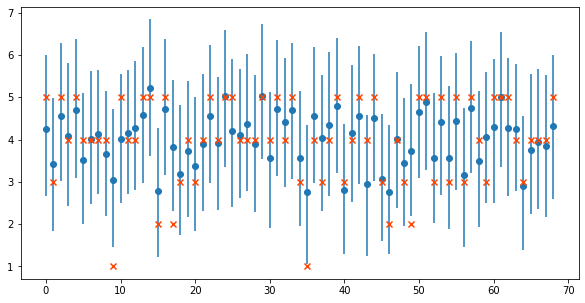

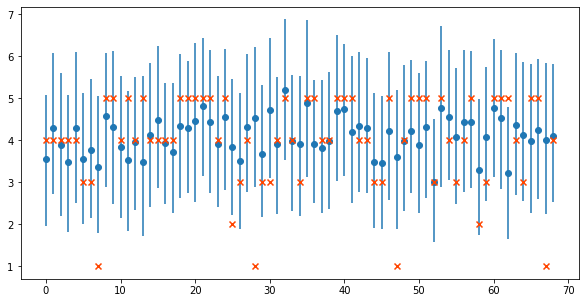

In [10]:
def _plot_ci(self, n, P, lower_bounds, upper_bounds, ax, *args,
             **kwargs):
    '''
    Plots credible intervals
    '''
    means = P.mean(axis=0)

    if ax is None:
        ax = plt.gca()

    ax.errorbar(range(n), means,
                yerr=[means-lower_bounds, upper_bounds-means],
                fmt='o', *args, **kwargs)

def ci(self, n_elements: int=20, row_inds: Iterable=None, 
       col_inds: Iterable=None, n_samples: int=1000, p=0.95, plot: bool=False, 
       ax: 'matplotlib.Axes'=None, *args, **kwargs):
    '''
    Computes credible intervals first elements of matrix.

    Parameters
    ------------
    n_elements: Number of elements to calculte credible intervals for, 
                no effect if col_inds and row_inds are given.
    row_inds: Optional, which row indices in X to show CIs for

    col_inds: Optional, which column indices in X to show CIs for

    n_samples: Number of samples to sample from predictive distribution

    p: Optional, credible interval percentage, 0.95 by default

    plot: Optional, to plot credible intervals or not, False by default

    ax: Optional, plots on given ax, no effect if show is False

    Returns
    --------
    (lower_bounds, upper_bounds)
    '''
    self.assert_fitted()

    # This is equivalent to Xs = np.array([U@V for U,V in zip(Us, Vs)])
    Xs = self.Us@self.Vs

    if (row_inds is None) or (col_inds is None):
        assert (row_inds and col_inds) is None,\
            "Either row_inds and col_inds are both None, or both Iterables"
        # Used to extract first n_elements from predicted Xs
        row_inds, col_inds = np.unravel_index(range(n_elements), Xs.shape[1:])

    assert len(row_inds) == len(col_inds),\
        "Length mismatch between row_inds and col_inds"

    # Sample from predictive distribution
    picks = np.random.randint(0, len(Xs), n_samples)
    P = Xs[picks][:,row_inds, col_inds]
    P = self._likelihood_sample(P, picks)
    P.sort(axis=0)

    # Get credible intervals of samples from predictive distribution
    half_p = (1-p)/2
    lb = np.floor((half_p*n_samples)).astype(int)
    ub = np.ceil((p+half_p)*n_samples).astype(int)

    lower_bounds, upper_bounds = P[lb], P[ub]
    
    if plot:
        _plot_ci(self, len(row_inds), P, lower_bounds, upper_bounds, ax, *args,
                    **kwargs)

    return lower_bounds, upper_bounds

def ci_df(self, df):
    fig, ax = plt.subplots(figsize=(10,5))
    ci(self, row_inds=df.user_id, col_inds=df.item_id, plot=True, zorder=0, ax=ax)
    ax.scatter(range(len(df)), df.rating, marker='x', c='orangered', zorder=1)
    plt.show()

ci_df(hist['model'][5], df_train.sample(n=69))
ci_df(hist['model'][5], df_val.sample(n=69))

In [11]:
df_hist.sort_values('val_mae')

,model,params,fit_time,train_mae,val_mae
7,<StanClasses.NonNegativeFactorizer object at 0...,{'n_components': 40},5973.190706,0.608221,0.706140
6,<StanClasses.NonNegativeFactorizer object at 0...,{'n_components': 30},1620.042690,0.590106,0.714440
5,<StanClasses.NonNegativeFactorizer object at 0...,{'n_components': 20},1397.458637,0.564449,0.721469
4,<StanClasses.NonNegativeFactorizer object at 0...,{'n_components': 10},799.434563,0.549785,0.725667
11,<StanClasses.ARD_Factorizer object at 0x7f99b7...,{'n_components': 40},6030.320011,0.552589,0.730425
10,<StanClasses.ARD_Factorizer object at 0x7f99b7...,{'n_components': 30},4793.342878,0.543609,0.734893
8,<StanClasses.ARD_Factorizer object at 0x7f99bd...,{'n_components': 10},1674.963489,0.536099,0.736567
9,<StanClasses.ARD_Factorizer object at 0x7f99b7...,{'n_components': 20},5403.942647,0.532842,0.741788
0,<StanClasses.SimpleFactorizer object at 0x7f99...,{'n_components': 10},685.746223,0.625222,0.761773
1,<StanClasses.SimpleFactorizer object at 0x7f99...,{'n_components': 20},944.576799,0.626147,0.839341


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Test Place

2 8


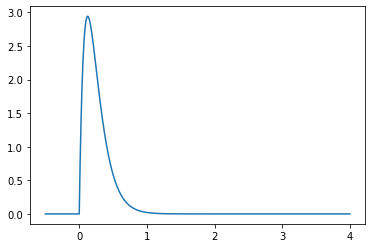

1 0.08


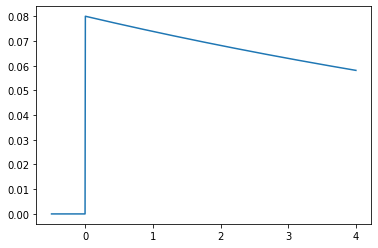

In [12]:
xrange = np.linspace(-0.5,4,1000)

a = 2
b = 4*a
y = stats.gamma.pdf(xrange, a=a, scale=1/b)
print(a, b)
plt.plot(xrange, y)
plt.show()

a = 1
b = 0.08*a
y = stats.gamma.pdf(xrange, a=a, scale=1/b)
print(a, b)
plt.plot(xrange, y)
# plt.axvline(((a-1)/b/(a-1)))
plt.show()

In [13]:
raise ValueError

ValueError: 

In [ ]:
sm_test_code = utils.get_stan_code('sanity.stan')
sm_test = utils.StanModel_cache(sm_test_code, 'test')

In [ ]:
fit_test = sm_test.sampling(algorithm="Fixed_param", chains=4, n_jobs=-1, iter=10)

In [ ]:
A = np.array([[0.674531,0.560879],[-1.82799,0.0132566]])

In [ ]:
A@A

In [ ]:
X_ = 